In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
import matplotlib.cm as cm
import datetime 
import time
from scipy.fft import fft, ifft, fftshift
from scipy.fftpack import fftfreq
from EOF import EOF
import gc
from multiprocessing import Pool
from Zonal_Calculation import Zonal_Calculation

# Plot EP flux for check

In [27]:
# Function to calculate EOF and PC
def Cal_EOF_PC(input_data):
    from EOF import EOF
    
    # Perform latitude weighting
    input_data_weighted = input_data * np.sqrt(np.cos(np.deg2rad(np.linspace(0, 90, input_data.shape[2]))))

    # Initialize an EOF instance with weighted input data
    n_component = min(input_data.shape[0], input_data.size // input_data.shape[0])

    eof_instance = EOF((input_data_weighted,), n_components=n_component, field="2D")
    eof_instance.get()

    # Retrieve EOFs and PCs and Extract EOF1, PC1, EOF2, and PC2
    EOF1, EOF2 = eof_instance.EOF[:2]
    PC1, PC2 = eof_instance.PC[:2]
    PC1_std = PC1.std()
    

    # Normalize PCs and EOFs
    PC1_norm, PC2_norm = (PC1 - PC1.mean()) / PC1.std(), (PC2 - PC2.mean()) / PC2.std()
    EOF1_norm, EOF2_norm = EOF1 * PC1.std(), EOF2 * PC2.std()
    return EOF1_norm.reshape(20,32), PC1_norm, EOF2_norm.reshape(20,32), PC2_norm, eof_instance.explained[:10]

In [28]:
PR = 0
n_std = 1 # to pick up which extremum out of std

# Read u
u_file  = f"/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF/PR{PR}/u/PR{PR}_500_20000day_6hourly_u_zonal_mean.h5"
u_file0 = h5py.File(u_file, "r")
Uzm       = np.asarray(u_file0["u"][:,:])

# Calculate EOF and PC
EOF1, PC1, EOF2, PC2, explained_all = Cal_EOF_PC(Uzm[:,:,32:])


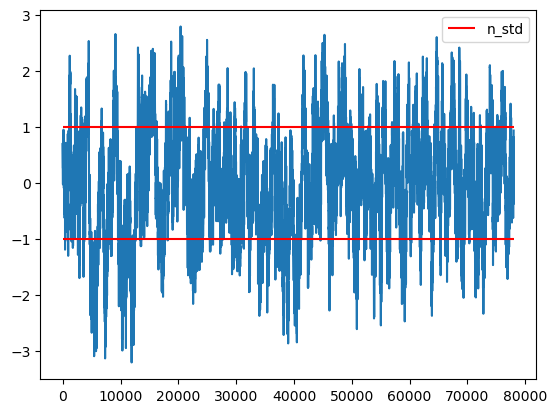

In [29]:
plt.figure()
plt.plot(PC1)
plt.hlines(y=n_std*PC1.std(), xmin=0, xmax=78000, color="Red", label="n_std")
plt.hlines(y=-n_std*PC1.std(), xmin=0, xmax=78000, color="Red")
plt.legend()

In [55]:
# get the time index of the extremum
time_idx = np.where(PC1>n_std*PC1.std())

# Read EP flux variable = -($\overline{u'v'}$)j + (${f0 \over N^2}$ $\overline{v'b'}$) k

In [30]:
# read EMF
def Read_var_simple(var, PR):
    str_var = str(var)
    common_path = "/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF/"
    last_path   = f"PR{PR}/{str_var}/PR{PR}_500_20000day_6hourly_{str_var}_zonal_mean.dat"        
    with h5py.File(common_path+last_path, 'r') as file:
        var = np.asarray(file[str_var][:])
    return var
    print("Got var!")    

In [31]:
# Constant
f0 = 2 * 7.29E-5 * np.sin(np.deg2rad(np.linspace(-90,90,64)))
g  = 9.81

# Read zonal mean vars
theta_zonal_mean_all = Read_var_simple("theta", PR)    
dtheta_all           = Read_var_simple("dtheta", PR)
dz_all               = Read_var_simple("dz", PR)
v_prime_b_prime_all  = Read_var_simple("v_prime_b_prime", PR)
EMF_all              = Read_var_simple("EMF", PR)

In [32]:
# Calculate 
dthetadz_all      = dtheta_all / dz_all
N_square_test_all = g / theta_zonal_mean_all * dthetadz_all

# EP flux j and k component
F_j =  EMF_all.mean(axis=0) # np.mean(EMF, axis=(0,3))
F_k = (f0[np.newaxis, np.newaxis, :] * v_prime_b_prime_all / N_square_test_all).mean(axis=0)

In [33]:
np.shape(theta_zonal_mean_all)

(78000, 20, 64)

In [34]:
# Lag = 5
time_idx_lag_5 = np.asarray(time_idx) + 5
print(np.shape(time_idx_lag_5))

z_idx, y_idx = np.shape(theta_zonal_mean_all)[1], np.shape(theta_zonal_mean_all)[2]

theta_zonal_mean_lag_5 = np.zeros(((np.shape(time_idx)[1], z_idx, y_idx)))
dtheta_lag_5           = np.zeros(((np.shape(time_idx)[1], z_idx, y_idx)))
dz_lag_5               = np.zeros(((np.shape(time_idx)[1], z_idx, y_idx)))
v_prime_b_prime_lag_5  = np.zeros(((np.shape(time_idx)[1], z_idx, y_idx)))
EMF_lag_5              = np.zeros(((np.shape(time_idx)[1], z_idx, y_idx)))

for i in range(np.shape(time_idx)[1]):
    theta_zonal_mean_lag_5[i] = theta_zonal_mean_all[time_idx_lag_5[0][i],:,:]
    dtheta_lag_5[i]           = dtheta_all[time_idx_lag_5[0][i],:,:]
    dz_lag_5[i]               = dz_all[time_idx_lag_5[0][i],:,:]
    v_prime_b_prime_lag_5[i]  = v_prime_b_prime_all[time_idx_lag_5[0][i],:,:]
    EMF_lag_5[i]              = EMF_all[time_idx_lag_5[0][i],:,:]
# Calculate 
dthetadz_lag_5      = dtheta_lag_5 / dz_lag_5
N_square_test_lag_5 = g / theta_zonal_mean_lag_5 * dthetadz_lag_5

# EP flux j and k component
F_j_lag_5 =  EMF_lag_5.mean(axis=0) # np.mean(EMF, axis=(0,3))
F_k_lag_5 = (f0[np.newaxis, np.newaxis, :] * v_prime_b_prime_lag_5 / N_square_test_lag_5).mean(axis=0)

NameError: name 'time_idx' is not defined

In [35]:
# Lag = -5
time_idx_negative_5 = np.asarray(time_idx) - 5
print(np.shape(time_idx_negative_5))

z_idx, y_idx = np.shape(theta_zonal_mean_all)[1], np.shape(theta_zonal_mean_all)[2]

theta_zonal_mean_negative_5 = np.zeros(((np.shape(time_idx)[1], z_idx, y_idx)))
dtheta_negative_5           = np.zeros(((np.shape(time_idx)[1], z_idx, y_idx)))
dz_negative_5               = np.zeros(((np.shape(time_idx)[1], z_idx, y_idx)))
v_prime_b_prime_negative_5  = np.zeros(((np.shape(time_idx)[1], z_idx, y_idx)))
EMF_negative_5              = np.zeros(((np.shape(time_idx)[1], z_idx, y_idx)))

for i in range(np.shape(time_idx)[1]):
    theta_zonal_mean_negative_5[i] = theta_zonal_mean_all[time_idx_negative_5[0][i],:,:]
    dtheta_negative_5[i]           = dtheta_all[time_idx_negative_5[0][i],:,:]
    dz_negative_5[i]               = dz_all[time_idx_negative_5[0][i],:,:]
    v_prime_b_prime_negative_5[i]  = v_prime_b_prime_all[time_idx_negative_5[0][i],:,:]
    EMF_negative_5[i]              = EMF_all[time_idx_negative_5[0][i],:,:]
# Calculate 
dthetadz_negative_5      = dtheta_negative_5 / dz_negative_5
N_square_test_negative_5 = g / theta_zonal_mean_negative_5 * dthetadz_negative_5

# EP flux j and k component
F_j_negative_5 =  EMF_negative_5.mean(axis=0) # np.mean(EMF, axis=(0,3))
F_k_negative_5 = (f0[np.newaxis, np.newaxis, :] * v_prime_b_prime_negative_5 / N_square_test_negative_5).mean(axis=0)

NameError: name 'time_idx' is not defined

# Plot

Text(0.5, 1.0, 'Lag = 5 PR = 0 EP flux')

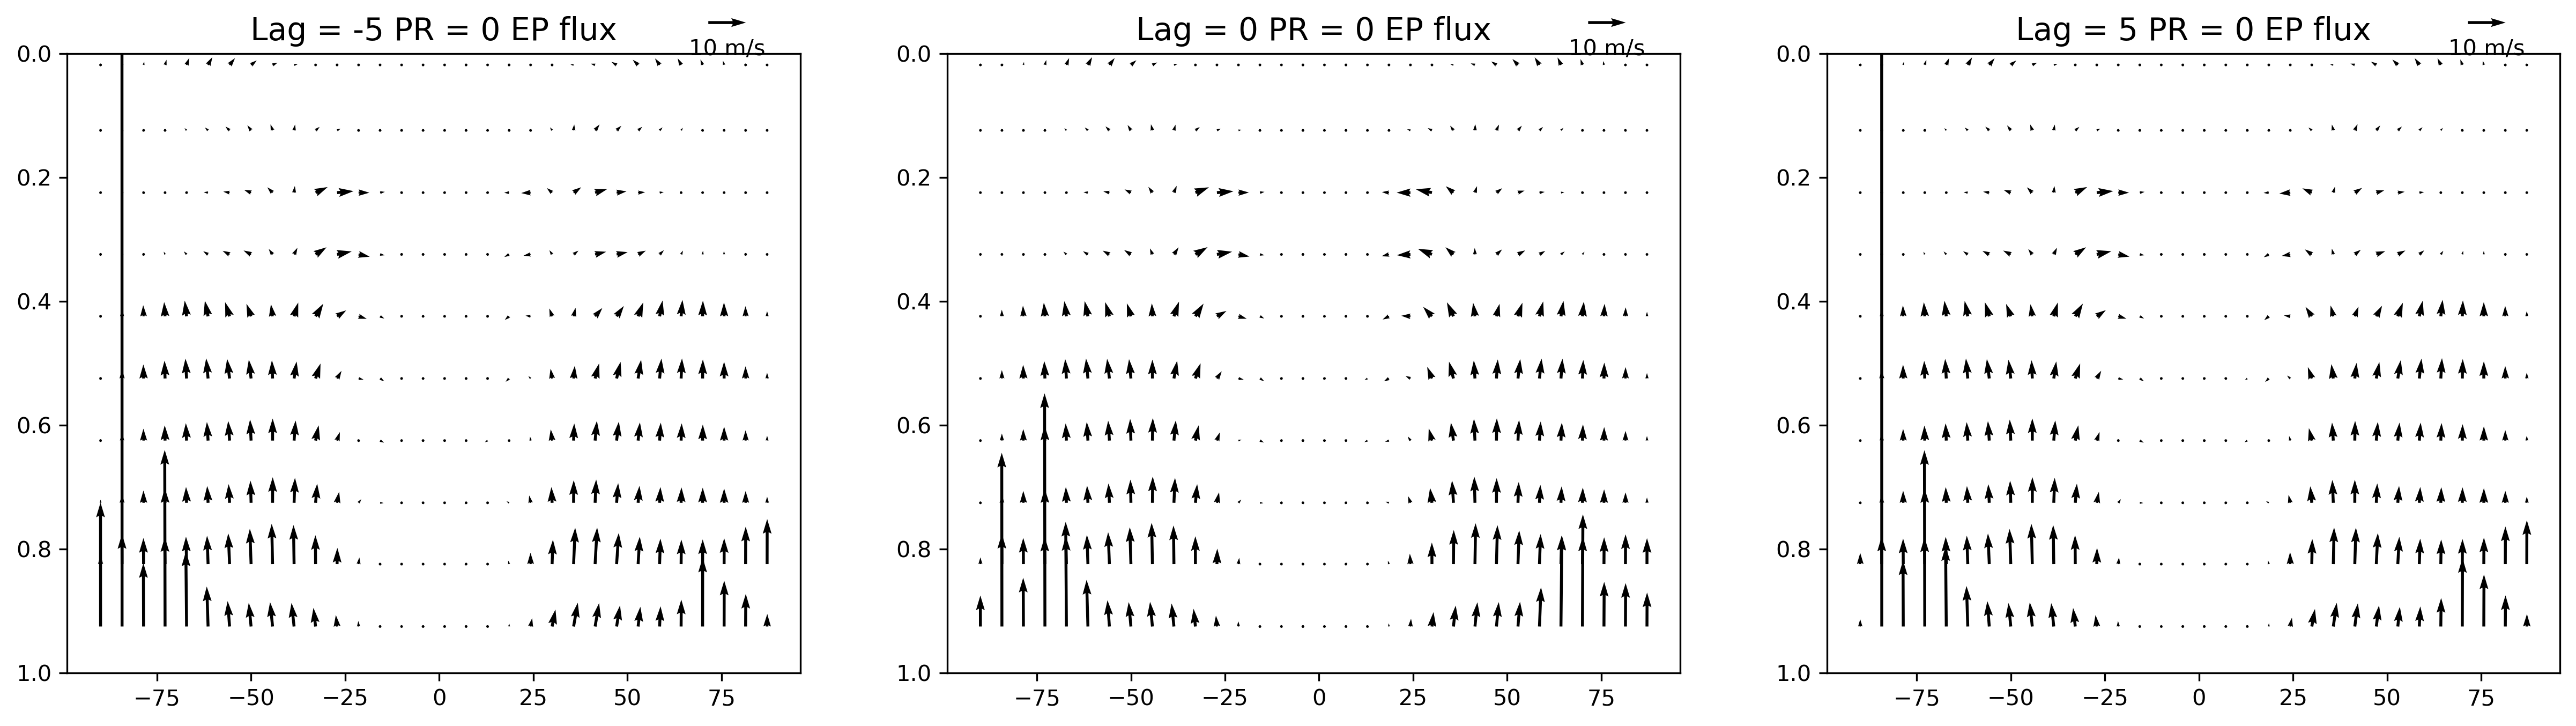

In [63]:
# idx = 2
# fig, ax = plt.subplots(1,3,figsize = (20,5), dpi=300)
# # Lag negative 5
# ax_right = ax[0].quiver(yy[::idx,::idx], zz[::idx,::idx], -F_j_negative_5[::idx,::idx], -F_k_negative_5[::idx,::idx], color="black",
#            scale_units='xy', angles='xy', width=4e-3, scale=10)
# ax[0].quiverkey(ax_right, X=0.9, Y=1.05, U=100, label=f"{int(100/10)} m/s", labelpos="S")
# ax[0].set_ylim([1,0])
# ax[0].set_title(f"Lag = -5 PR = {PR} EP flux", fontsize=14)

# ax_right = ax[1].quiver(yy[::idx,::idx], zz[::idx,::idx], -F_j[::idx,::idx], -F_k[::idx,::idx], color="black",
#            scale_units='xy', angles='xy', width=4e-3, scale=10)
# ax[1].quiverkey(ax_right, X=0.9, Y=1.05, U=100, label=f"{int(100/10)} m/s", labelpos="S")
# ax[1].set_ylim([1,0])
# ax[1].set_title(f"Lag = 0 PR = {PR} EP flux", fontsize=14)

# # Lag 5
# ax_right = ax[2].quiver(yy[::idx,::idx], zz[::idx,::idx], -F_j_lag_5[::idx,::idx], -F_k_lag_5[::idx,::idx], color="black",
#            scale_units='xy', angles='xy', width=4e-3, scale=10)
# ax[2].quiverkey(ax_right, X=0.9, Y=1.05, U=100, label=f"{int(100/10)} m/s", labelpos="S")
# ax[2].set_ylim([1,0])
# ax[2].set_title(f"Lag = 5 PR = {PR} EP flux", fontsize=14)

# Paper1 Fig.4-1

In [19]:
"""
ep_flux_mean_dir_1_1: Fig.4-1 lags_5_20: np.linspace(5*4,20*4,1)
ep_flux_mean_dir    : Fig.4-1 lags_5_20: np.linspace(15*4,20*4,1)
ep_flux_mean_dir_1_2: Fig.4-2 dot
"""


# Function to calculate EOF and PC
def Cal_EOF_PC(input_data):
    from EOF import EOF
    
    # Perform latitude weighting
    input_data_weighted = input_data * np.sqrt(np.cos(np.deg2rad(np.linspace(0, 90, input_data.shape[2]))))

    # Initialize an EOF instance with weighted input data
    n_component = min(input_data.shape[0], input_data.size // input_data.shape[0])

    eof_instance = EOF((input_data_weighted,), n_components=n_component, field="2D")
    eof_instance.get()

    # Retrieve EOFs and PCs and Extract EOF1, PC1, EOF2, and PC2
    EOF1, EOF2 = eof_instance.EOF[:2]
    PC1, PC2 = eof_instance.PC[:2]
    PC1_std = PC1.std()
    
    # Normalize PCs and EOFs
    PC1_norm, PC2_norm = (PC1 - PC1.mean()) / PC1.std(), (PC2 - PC2.mean()) / PC2.std()
    EOF1_norm, EOF2_norm = EOF1 * PC1.std(), EOF2 * PC2.std()
    
    return EOF1_norm.reshape(20,32), PC1_norm, EOF2_norm.reshape(20,32), PC2_norm, eof_instance.explained[:10], PC1_std

# Function to read data from HDF5
def Read_var_simple(var, PR):
    str_var = str(var)
    common_path = "/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF/"
    last_path = f"PR{PR}/{str_var}/PR{PR}_500_20000day_6hourly_{str_var}_zonal_mean.dat"
    with h5py.File(common_path + last_path, 'r') as file:
        data = np.asarray(file[str_var][:])
    return data

# Function to load saved components
def load_lagged_components(PR, lag, save_dir, suffix):
    F_j_lag = np.load(f"{save_dir}/F_j_lag_{lag}_PR_{PR}_{suffix}.npy")
    F_k_lag = np.load(f"{save_dir}/F_k_lag_{lag}_PR_{PR}_{suffix}.npy")
    return F_j_lag, F_k_lag

# Function to calculate and save lagged components for given time indices
def calculate_and_save_lagged_components(PR, lag, f0, g, save_dir, time_idx, suffix):
    # Read zonal mean variables
    theta_zonal_mean_all = Read_var_simple("theta", PR)
    dtheta_all           = Read_var_simple("dtheta", PR)
    dz_all               = Read_var_simple("dz", PR)
    v_prime_b_prime_all  = Read_var_simple("v_prime_b_prime", PR)
    EMF_all              = Read_var_simple("EMF", PR)

    # Calculate N squared
    dthetadz_all = dtheta_all / dz_all
    N_square_all = g / theta_zonal_mean_all * dthetadz_all

    # Calculate lagged indices
    time_idx_lag = np.asarray(time_idx) + lag
    z_idx, y_idx = theta_zonal_mean_all.shape[1], theta_zonal_mean_all.shape[2]

    theta_zonal_mean_lag = np.zeros((len(time_idx[0]), z_idx, y_idx))
    dtheta_lag           = np.zeros((len(time_idx[0]), z_idx, y_idx))
    dz_lag               = np.zeros((len(time_idx[0]), z_idx, y_idx))
    v_prime_b_prime_lag  = np.zeros((len(time_idx[0]), z_idx, y_idx))
    EMF_lag              = np.zeros((len(time_idx[0]), z_idx, y_idx))

    for i in range(len(time_idx[0])):
        theta_zonal_mean_lag[i] = theta_zonal_mean_all[time_idx_lag[0][i], :, :] 
        dtheta_lag[i]           = dtheta_all[time_idx_lag[0][i], :, :] 
        dz_lag[i]               = dz_all[time_idx_lag[0][i], :, :]
        v_prime_b_prime_lag[i]  = v_prime_b_prime_all[time_idx_lag[0][i], :, :] 
        EMF_lag[i]              = EMF_all[time_idx_lag[0][i], :, :] 

    dthetadz_lag = dtheta_lag / dz_lag
    N_square_lag = g / theta_zonal_mean_lag * dthetadz_lag

    F_j_long_time_mean = EMF_all.mean(axis=0)
    F_k_long_time_mean = (f0[np.newaxis, np.newaxis, :] * v_prime_b_prime_all / N_square_all).mean(axis=0) 
    
    F_j_lag = EMF_lag.mean(axis=0) - F_j_long_time_mean
    F_k_lag = (f0[np.newaxis, np.newaxis, :] * v_prime_b_prime_lag / N_square_lag).mean(axis=0) - F_k_long_time_mean

    # Save the results
    os.makedirs(save_dir, exist_ok=True)
    np.save(os.path.join(save_dir, f"F_j_lag_{lag}_PR_{PR}_{suffix}.npy"), F_j_lag)
    np.save(os.path.join(save_dir, f"F_k_lag_{lag}_PR_{PR}_{suffix}.npy"), F_k_lag)
    print(f"Saved F_j and F_k for PR={PR}, lag={lag}, condition={suffix}")

# Constants
f0 = 2 * 7.29E-5 * np.sin(np.deg2rad(np.linspace(-90, 90, 64)))
g = 9.81

# PR values and lags to process
PR_values  = range(0, 60, 10)
lags_5_20  = range(15*4, 25*4, 1)   # Lags corresponding to 15-20 days 
lags_30_60 = range(90*4, 100*4, 1)  # Lags corresponding to 90-100 days
save_dir          = "EP_flux_results"       # Directory to save results
pc1_save_dir      = "PC1_results"           # Directory to save PC1 results
time_idx_save_dir = "time_idx_results"      # Directory to save time_idx results
ep_flux_mean_dir  = "EP_flux_mean_results"  # Directory to save mean EP flux results

# Storage for EOFs and PCs across different PR values
EOF1_all_PRs = {}
EOF2_all_PRs = {}
PC1_all_PRs = {}
PC2_all_PRs = {}
explained_variance_PRs = {}
time_idx_PRs = {}
PC1_std_PRs = {}

# Ensure the mean EP flux directory exists
os.makedirs(ep_flux_mean_dir, exist_ok=True)

# Function to calculate mean EP flux over specified lags
def calculate_mean_flux(PR, lags, suffix):
    F_j_mean = np.zeros_like(np.load(f"{save_dir}/F_j_lag_{lags[0]}_PR_{PR}_positive.npy"))
    F_k_mean = np.zeros_like(np.load(f"{save_dir}/F_k_lag_{lags[0]}_PR_{PR}_positive.npy"))
    
    for lag in lags:
        F_j_positive, F_k_positive = load_lagged_components(PR, lag, save_dir, "positive")
        F_j_negative, F_k_negative = load_lagged_components(PR, lag, save_dir, "negative")
        
        F_j_mean += (F_j_positive - F_j_negative) 
        F_k_mean += (F_k_positive - F_k_negative) 
    
    F_j_mean /= len(lags)
    F_k_mean /= len(lags)
    
    np.save(os.path.join(ep_flux_mean_dir, f"F_j_mean_{suffix}_PR_{PR}.npy"), F_j_mean)
    np.save(os.path.join(ep_flux_mean_dir, f"F_k_mean_{suffix}_PR_{PR}.npy"), F_k_mean)

    return F_j_mean, F_k_mean

# Step 1: Calculate and save lagged components for each PR and lag
for PR in PR_values:
    print(f"Processing PR = {PR}")
    # Read the U data for the current PR
    u_file = f"/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF/PR{PR}/u/PR{PR}_500_20000day_6hourly_u_zonal_mean.h5"
    with h5py.File(u_file, "r") as u_file0:
        u_data = np.asarray(u_file0["u"][:,:])
    
    # Calculate EOFs and PCs for the current PR
    EOF1, PC1, EOF2, PC2, explained_variance, PC1_std = Cal_EOF_PC(u_data[:,:,32:])
    
    # Normalize the sign of EOF1
    if PR > 0:  # Assuming PR=0 is the baseline
        sign_correction = np.sign(np.dot(EOF1_all_PRs[PR_values[0]].reshape(-1), EOF1.reshape(-1)))
        EOF1 *= sign_correction
        PC1 *= sign_correction
    
    # Store the results
    EOF1_all_PRs[PR] = EOF1
    EOF2_all_PRs[PR] = EOF2
    PC1_all_PRs[PR] = PC1
    PC2_all_PRs[PR] = PC2
    explained_variance_PRs[PR] = explained_variance
    PC1_std_PRs[PR] = PC1_std
    
    # Save PC1 and EOF1 to file for later inspection
    os.makedirs(pc1_save_dir, exist_ok=True)
    np.save(os.path.join(pc1_save_dir, f"PC1_PR_{PR}.npy"), PC1)
    np.save(os.path.join(pc1_save_dir, f"EOF1_PR_{PR}.npy"), EOF1)
    np.save(os.path.join(pc1_save_dir, f"PC1_std_PR_{PR}.npy"), PC1_std)
    
    # Calculate time_idx for PC1 > 1*std
    time_idx_positive = np.where(PC1 > 1 * PC1.std())[0]
    time_idx_negative = np.where(PC1 < -1 * PC1.std())[0]
    
    # Adjust time_idx values if they exceed the limit
    max_idx = int(78000 - 100*4)
    time_idx_array_positive = time_idx_positive[time_idx_positive <= max_idx]
    time_idx_array_negative = time_idx_negative[time_idx_negative <= max_idx]

    # Save time_idx for PC1 > 2*std and < -2*std
    np.save(os.path.join(time_idx_save_dir, f"time_idx_positive_PR_{PR}.npy"), time_idx_array_positive)
    np.save(os.path.join(time_idx_save_dir, f"time_idx_negative_PR_{PR}.npy"), time_idx_array_negative)

    
    
    # Use calculate_and_save_lagged_components for all necessary lags
    for lag in list(lags_5_20) + list(lags_30_60):
        # You would need the time indices (time_idx) for this step
        # time_idx = np.arange(78000)  # Assuming this is how you would set time_idx; adjust as needed
        calculate_and_save_lagged_components(PR, lag, f0, g, save_dir, (time_idx_array_positive,), "positive")
        calculate_and_save_lagged_components(PR, lag, f0, g, save_dir, (time_idx_array_negative,), "negative")
    print(f"Completed PR = {PR}, time_idx length: {len(time_idx_array_positive)} (positive), {len(time_idx_array_negative)} (negative)")
    

# Step 2: Calculate mean EP flux for each PR and save the results
for PR in PR_values:
    print(f"Calculating mean EP flux for PR = {PR}")
    
    F_j_mean_5_20, F_k_mean_5_20 = calculate_mean_flux(PR, lags_5_20, "5_20")
    F_j_mean_30_60, F_k_mean_30_60 = calculate_mean_flux(PR, lags_30_60, "30_60")
    
    # Calculate the difference between the two means
    F_j_mean_diff = F_j_mean_5_20 - F_j_mean_30_60
    F_k_mean_diff = F_k_mean_5_20 - F_k_mean_30_60
    
    np.save(os.path.join(ep_flux_mean_dir, f"F_j_mean_diff_PR_{PR}.npy"), F_j_mean_diff)
    np.save(os.path.join(ep_flux_mean_dir, f"F_k_mean_diff_PR_{PR}.npy"), F_k_mean_diff)
    print(f"Saved EP flux difference for PR = {PR}")




Processing PR = 0
Saved F_j and F_k for PR=0, lag=60, condition=positive
Saved F_j and F_k for PR=0, lag=60, condition=negative
Saved F_j and F_k for PR=0, lag=61, condition=positive
Saved F_j and F_k for PR=0, lag=61, condition=negative
Saved F_j and F_k for PR=0, lag=62, condition=positive
Saved F_j and F_k for PR=0, lag=62, condition=negative
Saved F_j and F_k for PR=0, lag=63, condition=positive
Saved F_j and F_k for PR=0, lag=63, condition=negative
Saved F_j and F_k for PR=0, lag=64, condition=positive
Saved F_j and F_k for PR=0, lag=64, condition=negative
Saved F_j and F_k for PR=0, lag=65, condition=positive
Saved F_j and F_k for PR=0, lag=65, condition=negative
Saved F_j and F_k for PR=0, lag=66, condition=positive
Saved F_j and F_k for PR=0, lag=66, condition=negative
Saved F_j and F_k for PR=0, lag=67, condition=positive
Saved F_j and F_k for PR=0, lag=67, condition=negative
Saved F_j and F_k for PR=0, lag=68, condition=positive
Saved F_j and F_k for PR=0, lag=68, condition=n

<>:55: SyntaxWarning: invalid escape sequence '\o'
<>:56: SyntaxWarning: invalid escape sequence '\d'
<>:55: SyntaxWarning: invalid escape sequence '\o'
<>:56: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_1593420/2569422562.py:55: SyntaxWarning: invalid escape sequence '\o'
  ax.set_title(f"L = {PR * 0.01}: " + "EOF([$\overline{u}$]) and difference between L = 0 in EP Flux [$m^2/s^2$]", fontsize=13, loc="left")
/tmp/ipykernel_1593420/2569422562.py:56: SyntaxWarning: invalid escape sequence '\d'
  ax.set_xlabel("Latitude[$\degree$]", fontsize=8)


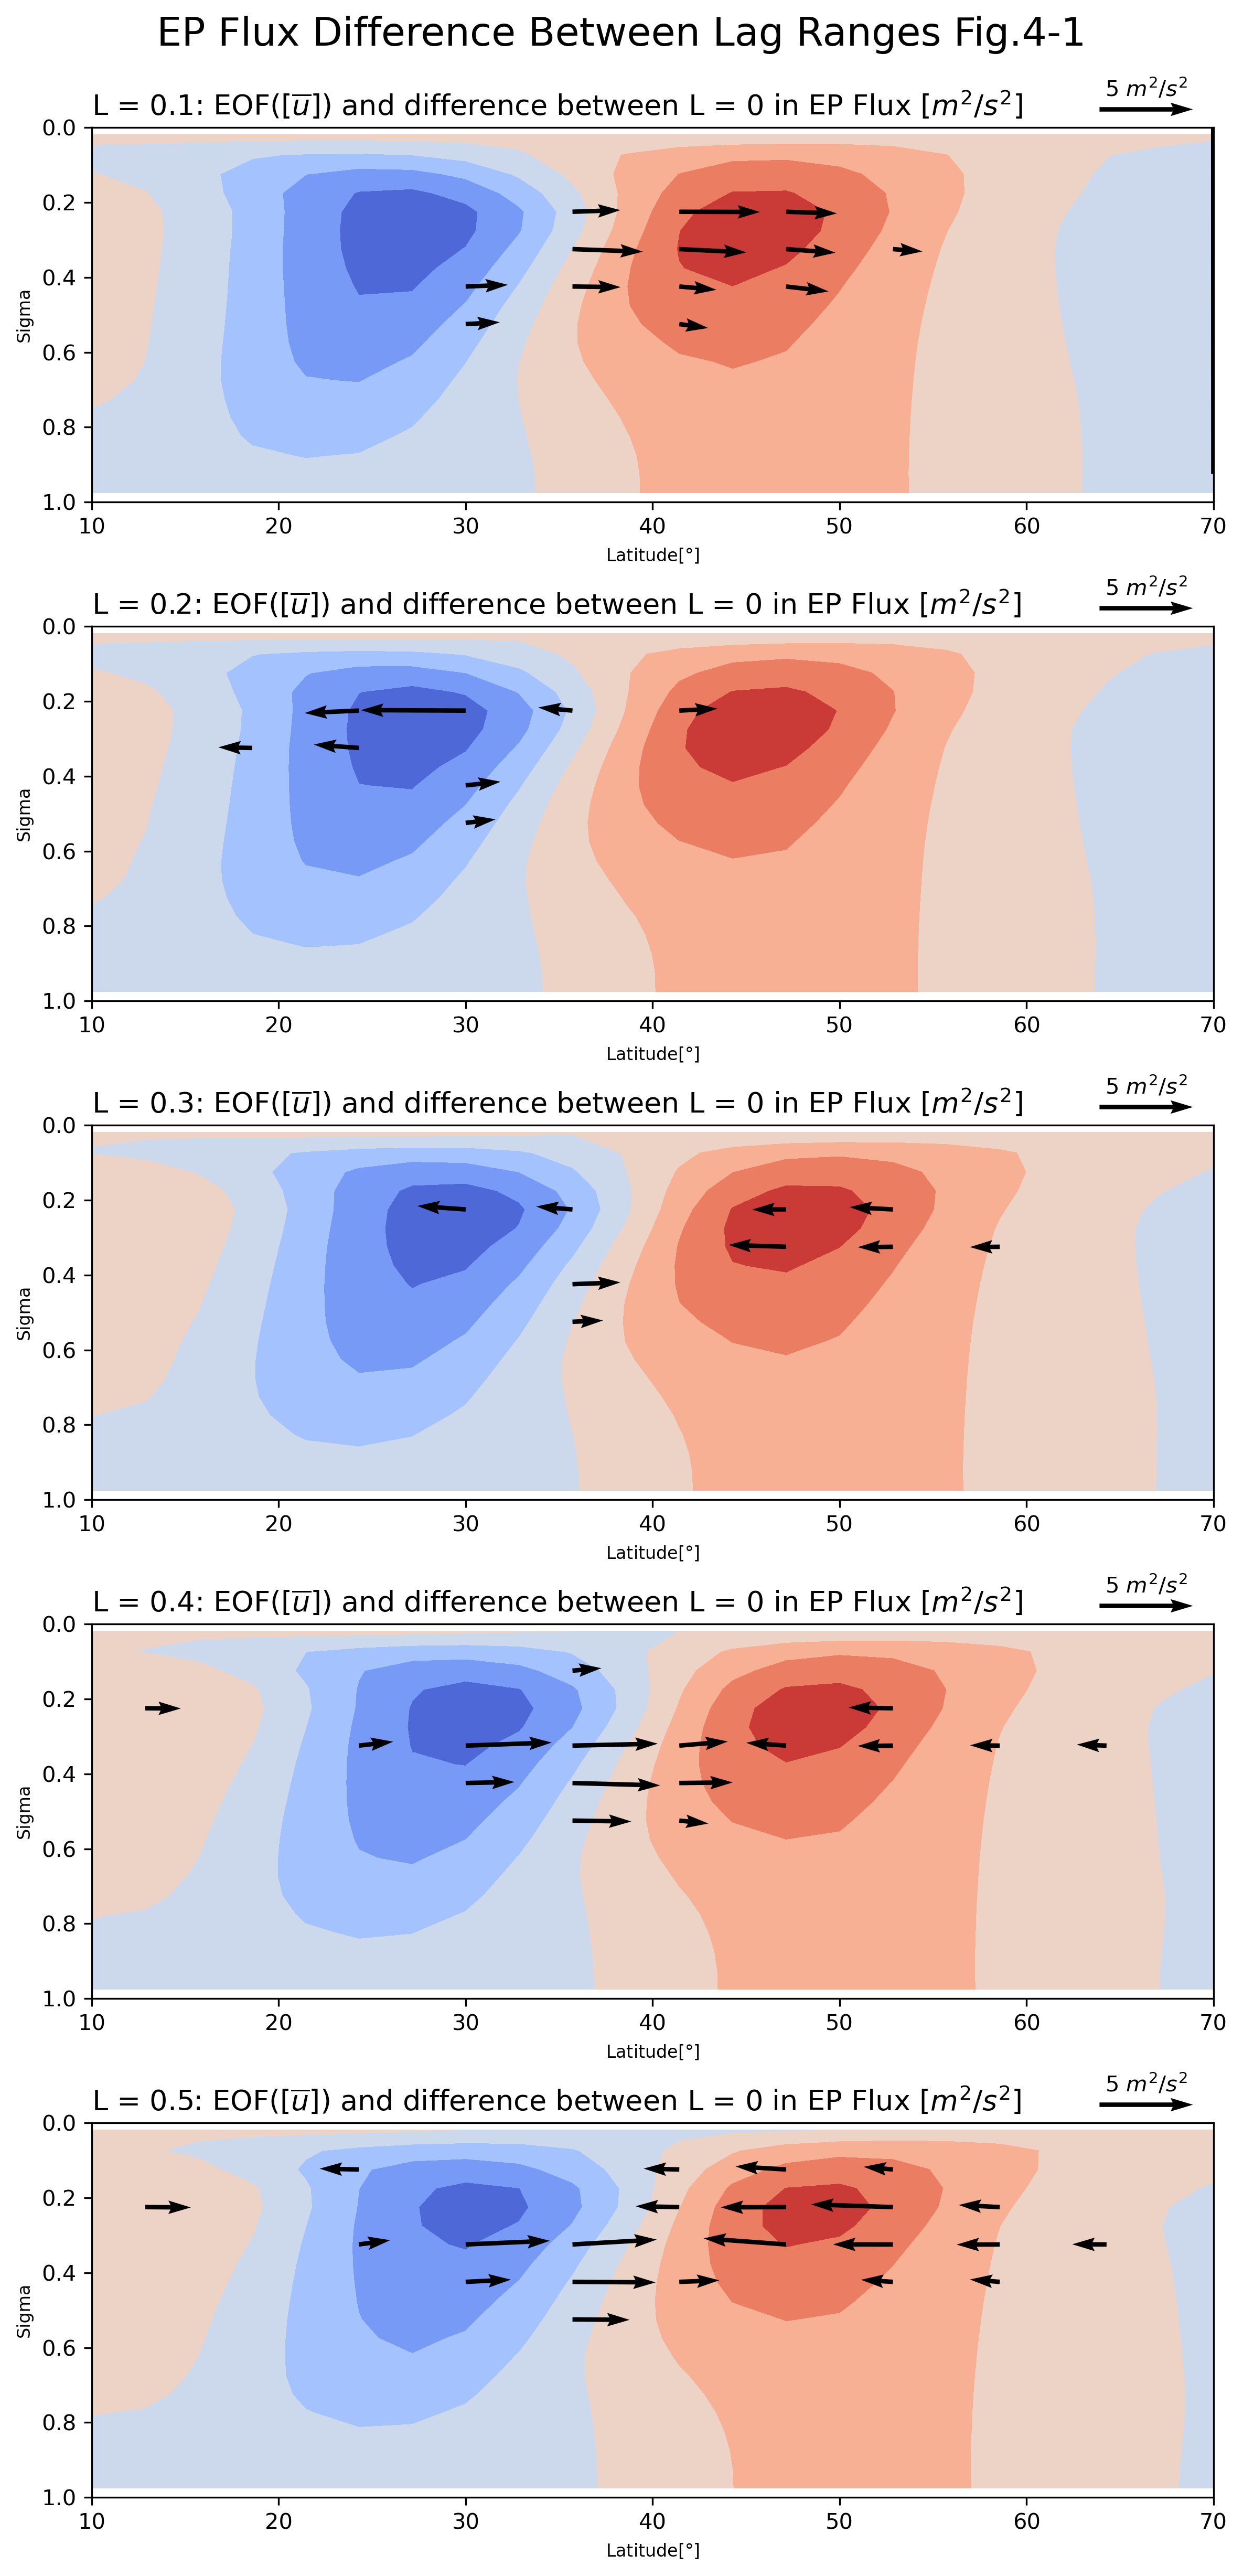

In [345]:
def load_EOF(PR, save_dir):
    EOF1 = np.load(f"{save_dir}/EOF1_PR_{PR}.npy")
    return EOF1
PR_values = range(10, 60, 10)

# Step 3: Plotting the difference in EP flux between lag = 5-20 day mean and lag = 30-60 day mean
fig, axes = plt.subplots(int(len(PR_values)), 1, figsize=(8, 16), dpi=300)

# load the EP flux components
F_j_mean_diff_PR0 = np.load(os.path.join(ep_flux_mean_dir, f"F_j_mean_diff_PR_0.npy"))
F_k_mean_diff_PR0 = np.load(os.path.join(ep_flux_mean_dir, f"F_k_mean_diff_PR_0.npy"))

NH_idx = 32
threshold = 3  # Wind speed threshold in m/s

for j, PR in enumerate(PR_values):
    # j = j-1
    F_j_mean_diff = np.load(os.path.join(ep_flux_mean_dir, f"F_j_mean_diff_PR_{PR}.npy"))
    F_k_mean_diff = np.load(os.path.join(ep_flux_mean_dir, f"F_k_mean_diff_PR_{PR}.npy"))

    # Load sigma for contour plotting
    sigma_file = f"/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF/PR{PR}/sigma/PR{PR}_500_20000day_6hourly_sigma_only_z.dat"
    with h5py.File(sigma_file, "r") as sigma_file0:
        sigma = np.asarray(sigma_file0["sigma"][:])

    y = np.linspace(-90, 90, 64)
    yy, zz = np.meshgrid(y, sigma)

    # Plot the difference in EP flux
    ax = axes[j]
    EOF1_PRs = load_EOF(PR, "PC1_results")
    ax.contourf(yy[:,32:], zz[:,32:], -EOF1_PRs, cmap='coolwarm')
    F_j_diff_final = (F_j_mean_diff[::, NH_idx::] - F_j_mean_diff_PR0[::, NH_idx::])
    F_k_diff_final = (F_k_mean_diff[::, NH_idx::] - F_k_mean_diff_PR0[::, NH_idx::])

    # Calculate wind speeds and create a mask for speeds below the threshold
    wind_speed = np.sqrt(F_j_diff_final**2 + F_k_diff_final**2)
    mask = (wind_speed >= threshold) | (wind_speed <= -threshold)
    
    # Apply the mask to filter out low-speed arrows
    F_j_diff_final = np.where(mask, F_j_diff_final, np.nan)
    F_k_diff_final = np.where(mask, F_k_diff_final, np.nan)

    

    wind_plt = ax.quiver(yy[::2, NH_idx::2], zz[::2, NH_idx::2], F_j_diff_final[::2, ::2], F_k_diff_final[::2, ::2],
              color="black", scale_units='xy', angles='xy', width=4e-3, scale=2)
    # ax.quiver(yy[::2, ::2], zz[::2, ::2], -(F_j_mean_diff[::2, ::2]), -(F_k_mean_diff[::2, ::2]),
              # color="black", scale_units='xy', angles='xy', width=4e-3, scale=2)

    ax.quiverkey(wind_plt,0.94,1.05,10,r'5 $m^2/s^2$',labelpos='N', labelsep =0.05, color='black')
    
    ax.set_ylim([1, 0])
    ax.set_xlim([10,70])
    ax.set_title(f"L = {PR * 0.01}: " + "EOF([$\overline{u}$]) and difference between L = 0 in EP Flux [$m^2/s^2$]", fontsize=13, loc="left")
    ax.set_xlabel("Latitude[$\degree$]", fontsize=8)
    ax.set_ylabel("Sigma", fontsize=8)
    

plt.tight_layout()
plt.suptitle("EP Flux Difference Between Lag Ranges Fig.4-1", fontsize=18, y=1.02)
# plt.savefig("Fig4-1_0912testing.png", bbox_inches='tight', dpi=300.)
plt.show()

# Fig.4-2

## Calcualte all time EP flux

In [339]:
import numpy as np
import os

# Function to calculate and save EP flux components for all time steps
def calculate_and_save_alltime_anamoly_ep_flux_components(PR, f0, g, save_dir, suffix):
    # Read zonal mean variables for all time steps
    theta_zonal_mean_all = Read_var_simple("theta", PR)
    dtheta_all = Read_var_simple("dtheta", PR)
    dz_all = Read_var_simple("dz", PR)
    v_prime_b_prime_all = Read_var_simple("v_prime_b_prime", PR)
    EMF_all = Read_var_simple("EMF", PR)

    # Calculate N squared for all time steps
    dthetadz_all = dtheta_all / dz_all
    N_square_all = g / theta_zonal_mean_all * dthetadz_all

    # Calculate the EP flux components for all time steps
    F_j = EMF_all # F_j at each time step
    F_k = f0[np.newaxis, np.newaxis, :] * v_prime_b_prime_all / N_square_all  # F_k at each time step

    # Calculate EP flux time mean
    F_j_mean = F_j.mean(axis=0)
    F_k_mean = F_k.mean(axis=0)

    # Calculate EP flux anamoly
    F_j_anamoly = F_j - F_j_mean
    F_k_anamoly = F_k - F_k_mean
    
    # Save the results for each time step
    os.makedirs(save_dir, exist_ok=True)
    np.save(os.path.join(save_dir, f"F_j_PR_{PR}_{suffix}.npy"), F_j_anamoly)
    np.save(os.path.join(save_dir, f"F_k_PR_{PR}_{suffix}.npy"), F_k_anamoly)
    print(f"Saved F_j and F_k for PR={PR}, condition={suffix}")
    

    # Save the all time EP flux 
    np.save(os.path.join(save_dir, f"F_j_PR_{PR}_all_time.npy"), F_j)
    np.save(os.path.join(save_dir, f"F_k_PR_{PR}_all_time.npy"), F_k)
    print(f"Saved F_j and F_k for PR={PR}, condition= all time")

In [340]:
# Set the directory to save all time EP flux results
ep_flux_all_time_dir = "EP_flux_all_time_results"

# Loop to calculate and save EP flux components for each PR value
for PR in PR_values:
    calculate_and_save_alltime_anamoly_ep_flux_components(PR, f0, g, ep_flux_all_time_dir, "anamoly")

Saved F_j and F_k for PR=10, condition=anamoly
Saved F_j and F_k for PR=10, condition= all time
Saved F_j and F_k for PR=20, condition=anamoly
Saved F_j and F_k for PR=20, condition= all time
Saved F_j and F_k for PR=30, condition=anamoly
Saved F_j and F_k for PR=30, condition= all time
Saved F_j and F_k for PR=40, condition=anamoly
Saved F_j and F_k for PR=40, condition= all time
Saved F_j and F_k for PR=50, condition=anamoly
Saved F_j and F_k for PR=50, condition= all time


In [7]:
# Ensure the directory exists for loading
ep_flux_all_time_dir = "EP_flux_all_time_results"
os.makedirs(ep_flux_all_time_dir, exist_ok=True)

# Load the EP flux components
F_j_anamoly_PR0 = np.load(os.path.join(ep_flux_all_time_dir, f"F_j_PR_0_anamoly.npy"))
F_k_anamoly_PR0 = np.load(os.path.join(ep_flux_all_time_dir, f"F_k_PR_0_anamoly.npy"))

In [8]:
F_j_anamoly_PR0.shape

(78000, 20, 64)

# Fig.4-1 and Fig.4-2 Calculation and plot

In [341]:
import numpy as np
import os
import matplotlib.pyplot as plt
import h5py
import gc
from multiprocessing import Pool
from EOF import EOF

# Constants
f0 = 2 * 7.29E-5 * np.sin(np.deg2rad(np.linspace(-90, 90, 64)))
g = 9.81

# # PR values and lags to process
PR_values = range(10, 60, 10)
# lags_5_20 = range(5 * 4, 25 * 4, 1)  # Lags corresponding to 5-20 days
# lags_30_60 = range(90 * 4, 100 * 4, 1)  # Lags corresponding to 30-60 days

# # Directories to save results for Fig. 1-1
# save_dir_1_1 = "EP_flux_results_fig1_1"
# pc1_save_dir_1_1 = "PC1_results_fig1_1"
# time_idx_save_dir_1_1 = "time_idx_results_fig1_1"
# ep_flux_mean_dir_1_1 = "EP_flux_mean_results_fig1_1"

# Directories to save results for Fig. 1-2
save_dir_1_2 = "EP_flux_results_fig1_2"
pc1_save_dir_1_2 = "PC1_results_fig1_2"
time_idx_save_dir_1_2 = "time_idx_results_fig1_2"
ep_flux_mean_dir_1_2 = "EP_flux_mean_results_fig1_2"

ep_flux_all_time_dir = "EP_flux_all_time_results"

# Ensure all directories exist
for directory in [pc1_save_dir_1_1, time_idx_save_dir_1_1, ep_flux_mean_dir_1_1, save_dir_1_1,
                  pc1_save_dir_1_2, time_idx_save_dir_1_2, ep_flux_mean_dir_1_2, save_dir_1_2]:
    os.makedirs(directory, exist_ok=True)

# Function to calculate EOF and PC
def Cal_EOF_PC(input_data):
    input_data_weighted = input_data * np.sqrt(np.cos(np.deg2rad(np.linspace(0, 90, input_data.shape[2]))))
    n_component = min(input_data.shape[0], input_data.size // input_data.shape[0])

    eof_instance = EOF((input_data_weighted,), n_components=n_component, field="2D")
    eof_instance.get()

    EOF1, EOF2 = eof_instance.EOF[:2]
    PC1, PC2 = eof_instance.PC[:2]
    PC1_std = PC1.std()

    PC1_norm, PC2_norm = (PC1 - PC1.mean()) / PC1.std(), (PC2 - PC2.mean()) / PC2.std()
    EOF1_norm, EOF2_norm = EOF1 * PC1.std(), EOF2 * PC2.std()

    return EOF1_norm.reshape(20, 32), PC1_norm, EOF2_norm.reshape(20, 32), PC2_norm, eof_instance.explained[:10], PC1_std

# Function to read data from HDF5
def Read_var_simple(var, PR):
    common_path = "/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF/"
    last_path = f"PR{PR}/{var}/PR{PR}_500_20000day_6hourly_{var}_zonal_mean.dat"
    with h5py.File(common_path + last_path, 'r') as file:
        data = np.asarray(file[var][:])
    return data

# Function to calculate lagged components
def calculate_lagged_components(PR, lag, f0, g, time_idx, suffix, save_dir):
    theta_zonal_mean_all = Read_var_simple("theta", PR)
    dtheta_all = Read_var_simple("dtheta", PR)
    dz_all = Read_var_simple("dz", PR)
    v_prime_b_prime_all = Read_var_simple("v_prime_b_prime", PR)
    EMF_all = Read_var_simple("EMF", PR)

    dthetadz_all = dtheta_all / dz_all
    N_square_all = g / theta_zonal_mean_all * dthetadz_all

    time_idx_lag = np.asarray(time_idx) + lag
    theta_zonal_mean_lag = theta_zonal_mean_all[time_idx_lag[0], :, :]
    dtheta_lag = dtheta_all[time_idx_lag[0], :, :]
    dz_lag = dz_all[time_idx_lag[0], :, :]
    v_prime_b_prime_lag = v_prime_b_prime_all[time_idx_lag[0], :, :]
    EMF_lag = EMF_all[time_idx_lag[0], :, :]

    dthetadz_lag = dtheta_lag / dz_lag
    N_square_lag = g / theta_zonal_mean_lag * dthetadz_lag

    F_j_lag = EMF_lag.mean(axis=0) - EMF_all.mean(axis=0)
    F_k_lag = (f0[np.newaxis, np.newaxis, :] * v_prime_b_prime_lag / N_square_lag).mean(axis=0) - \
              (f0[np.newaxis, np.newaxis, :] * v_prime_b_prime_all / N_square_all).mean(axis=0)

    np.save(os.path.join(save_dir, f"F_j_lag_{lag}_PR_{PR}_{suffix}.npy"), F_j_lag)
    np.save(os.path.join(save_dir, f"F_k_lag_{lag}_PR_{PR}_{suffix}.npy"), F_k_lag)
    print(f"Saved F_j and F_k for PR={PR}, lag={lag}, condition={suffix}")


# Function to calculate and save mean EP flux
def calculate_mean_flux(PR, lags, suffix, ep_flux_mean_dir, save_dir):
    F_j_mean, F_k_mean = 0, 0
    
    for lag in lags:
        F_j_positive, F_k_positive = np.load(f"{save_dir}/F_j_lag_{lag}_PR_{PR}_positive.npy"), \
                                     np.load(f"{save_dir}/F_k_lag_{lag}_PR_{PR}_positive.npy")
        F_j_negative, F_k_negative = np.load(f"{save_dir}/F_j_lag_{lag}_PR_{PR}_negative.npy"), \
                                     np.load(f"{save_dir}/F_k_lag_{lag}_PR_{PR}_negative.npy")
        
        F_j_mean += (F_j_positive - F_j_negative)
        F_k_mean += (F_k_positive - F_k_negative)
    
    F_j_mean /= len(lags)
    F_k_mean /= len(lags)

    np.save(os.path.join(ep_flux_mean_dir, f"F_j_mean_{suffix}_PR_{PR}.npy"), F_j_mean)
    np.save(os.path.join(ep_flux_mean_dir, f"F_k_mean_{suffix}_PR_{PR}.npy"), F_k_mean)
    
    return F_j_mean, F_k_mean

# Main processing function for Fig. 1-2
def process_PR_fig1_2(PR):
    """
    Processing function for Fig. 1-2. Calculates and saves the time indices 
    where anomalies are above or below 2 standard deviations.
    """
    # if PR ==0:
        # continue
        
    print(f"Processing PR = {PR} for Fig. 1-2")

    # Load the EP flux components for PR=0 for reference
    F_j_mean_diff_PR0 = np.load(os.path.join(ep_flux_mean_dir, f"F_j_mean_diff_PR_0.npy"))
    F_k_mean_diff_PR0 = np.load(os.path.join(ep_flux_mean_dir, f"F_k_mean_diff_PR_0.npy")) # (78000, 20, 32)

    # Load the EP flux components for the current PR
    F_j_mean_diff = np.load(os.path.join(ep_flux_mean_dir, f"F_j_mean_diff_PR_{PR}.npy")) # Have to fig1-1 to read the result of difference in EP flux 
    F_k_mean_diff = np.load(os.path.join(ep_flux_mean_dir, f"F_k_mean_diff_PR_{PR}.npy")) # (78000, 20, 32)

    # Load the EP flux anomalies
    F_j_anamoly = np.load(os.path.join(ep_flux_all_time_dir, f"F_j_PR_{PR}_anamoly.npy")) # (78000, 20, 64)
    F_k_anamoly = np.load(os.path.join(ep_flux_all_time_dir, f"F_k_PR_{PR}_anamoly.npy"))

    NH_idx = 32
    NH_max_idx = 64
    reshape_idx = int(NH_max_idx - NH_idx)

    # Compute the difference between the current PR and PR=0
    F_j_diff_final = F_j_mean_diff[::, NH_idx:] - F_j_mean_diff_PR0[::, NH_idx:]
    F_k_diff_final = F_k_mean_diff[::, NH_idx:] - F_k_mean_diff_PR0[::, NH_idx:]


    # Calculase final_j and final_k without NaNs affecting the dot product
    F_j_anamoly_weighted = F_j_anamoly * np.cos(np.deg2rad(np.linspace(-90, 90, 64)))**0.5
    F_k_anamoly_weighted = F_k_anamoly * np.cos(np.deg2rad(np.linspace(-90, 90, 64)))**0.5

    F_j_diff_final_weighted = F_j_diff_final * np.cos(np.deg2rad(np.linspace(0,90,32)))**0.5
    F_k_diff_final_weighted = F_k_diff_final * np.cos(np.deg2rad(np.linspace(0,90,32)))**0.5
    
    
    final_j = F_j_anamoly_weighted[:, :, NH_idx:NH_max_idx].reshape(78000, 20 * reshape_idx).dot(
        F_j_diff_final_weighted[:, :].reshape(20 * reshape_idx)
    )
    final_k = F_k_anamoly_weighted[:, :, NH_idx:NH_max_idx].reshape(78000, 20 * reshape_idx).dot(
        F_k_diff_final_weighted[:, :].reshape(20 * reshape_idx)
    )

    # Calculate standardized final_j and final_k for this PR
    final_j_stand = (final_j - final_j.mean()) / final_j.std()
    final_k_stand = (final_k - final_k.mean()) / final_k.std()
    pc1_save_dir = "PC1_results"
    PC1 = np.load(os.path.join(pc1_save_dir, f"PC1_PR_{PR}.npy"))
    np.save(os.path.join(pc1_save_dir_1_2, f"PC1_PR_{PR}.npy"), final_j_stand)

    # Identify indices where the standardized values are above or below 2 standard deviations
    time_idx_positive = np.where(final_j_stand > 1)[0]
    time_idx_negative = np.where(final_j_stand < -1)[0]
    
    max_idx = int(78000 - 100 * 4)
    time_idx_array_positive = time_idx_positive[time_idx_positive <= max_idx]
    time_idx_array_negative = time_idx_negative[time_idx_negative <= max_idx]
    print(time_idx_array_positive.shape)

    np.save(os.path.join(time_idx_save_dir_1_2, f"time_idx_positive_PR_{PR}.npy"), time_idx_array_positive)
    np.save(os.path.join(time_idx_save_dir_1_2, f"time_idx_negative_PR_{PR}.npy"), time_idx_array_negative)


    print(f"Saved time indices for PR = {PR} for Fig. 1-2")

if __name__ == "__main__":

    # Process Fig. 1-2
    with Pool(processes=1) as pool:
        pool.map(process_PR_fig1_2, PR_values)

    gc.collect()


    


Processing PR = 10 for Fig. 1-2
(11857,)
Saved time indices for PR = 10 for Fig. 1-2
Processing PR = 20 for Fig. 1-2
(11818,)
Saved time indices for PR = 20 for Fig. 1-2
Processing PR = 30 for Fig. 1-2
(11482,)
Saved time indices for PR = 30 for Fig. 1-2
Processing PR = 40 for Fig. 1-2
(11950,)
Saved time indices for PR = 40 for Fig. 1-2
Processing PR = 50 for Fig. 1-2
(11849,)
Saved time indices for PR = 50 for Fig. 1-2


Checking time indices for PR=10
time_idx_positive shape for PR=10: (11857,)
time_idx_negative shape for PR=10: (11933,)


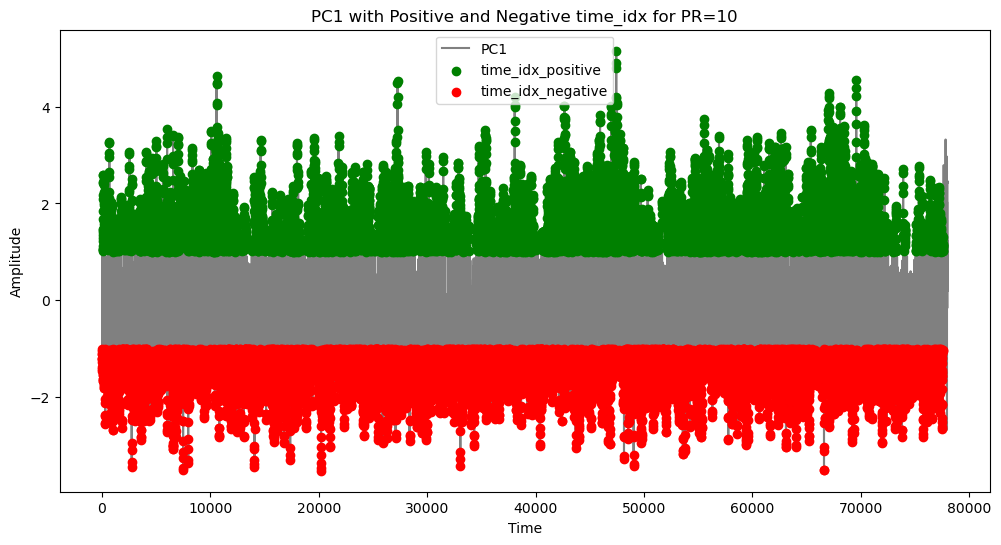

Checking time indices for PR=20
time_idx_positive shape for PR=20: (11818,)
time_idx_negative shape for PR=20: (11893,)


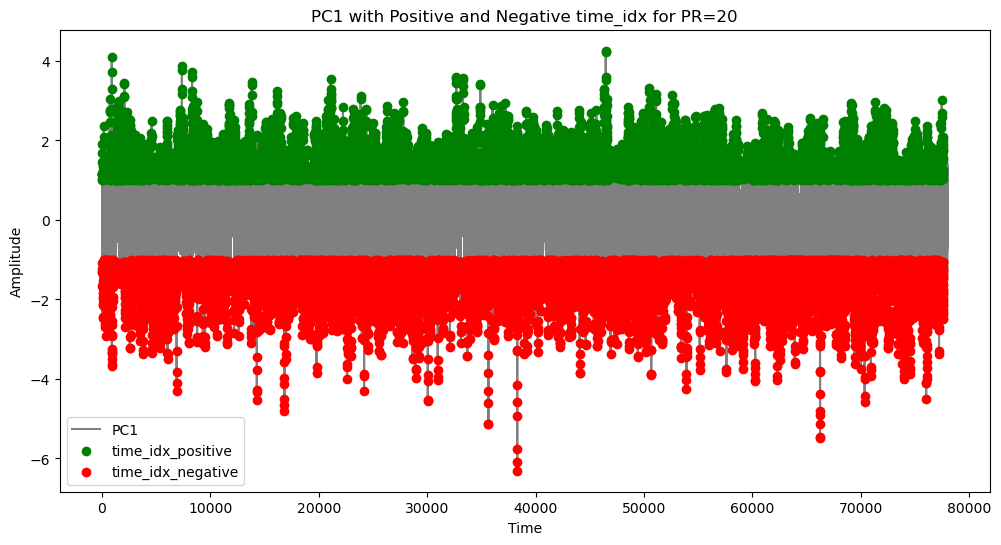

Checking time indices for PR=30
time_idx_positive shape for PR=30: (11482,)
time_idx_negative shape for PR=30: (11618,)


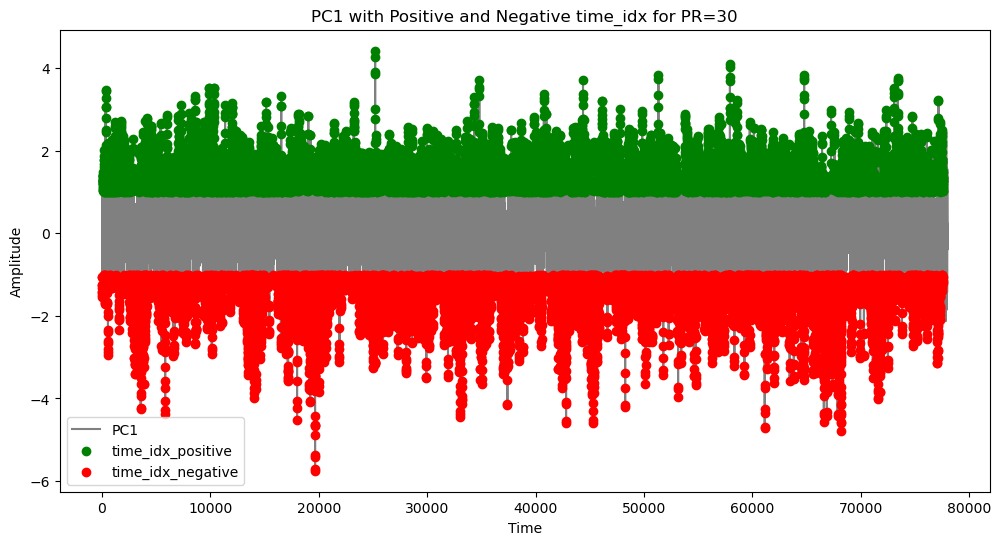

Checking time indices for PR=40
time_idx_positive shape for PR=40: (11950,)
time_idx_negative shape for PR=40: (12060,)


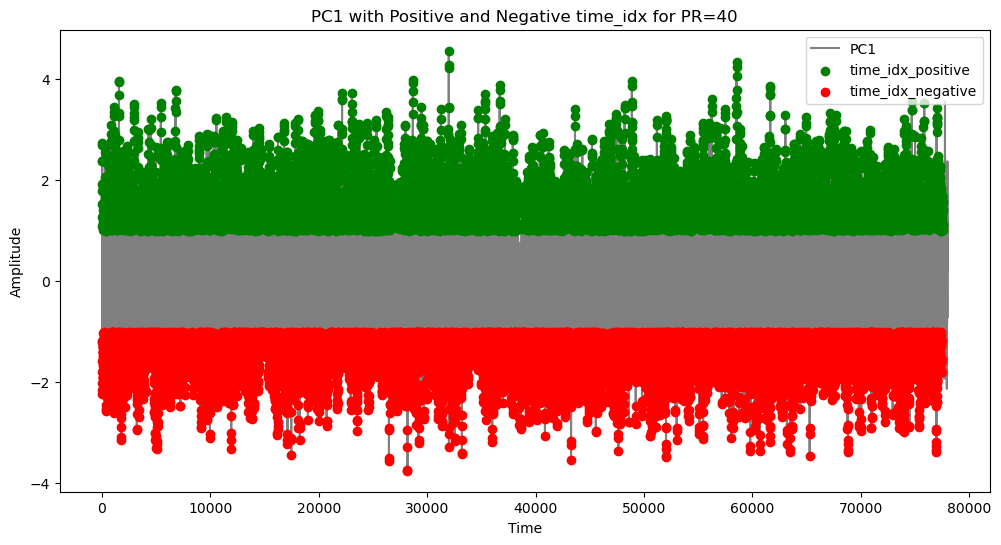

Checking time indices for PR=50
time_idx_positive shape for PR=50: (11849,)
time_idx_negative shape for PR=50: (11881,)


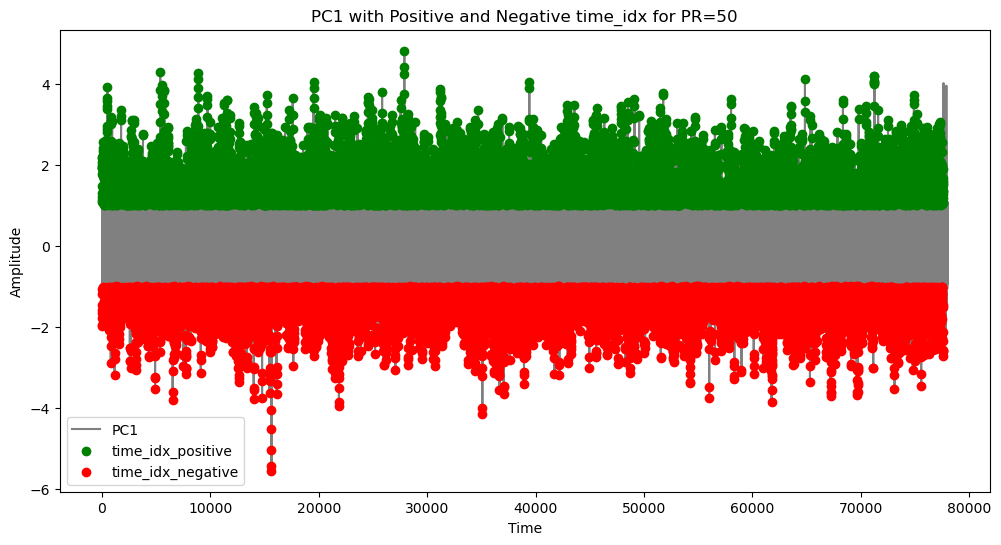

All time indices checked.


In [342]:
import numpy as np
import h5py
import os
import matplotlib.pyplot as plt

# Define directories
# time_idx_save_dir_1_2 = "time_idx_results_1_2"
time_idx_save_dir_1_2 = "time_idx_results_fig1_2"

# PR values to check
PR_values_time_series = range(10, 60, 10)

# Loop over PR values to check time_idx_positive and time_idx_negative
for PR in PR_values_time_series:
    print(f"Checking time indices for PR={PR}")

    # Load positive time indices
    time_idx_positive = np.load(os.path.join(time_idx_save_dir_1_2, f"time_idx_positive_PR_{PR}.npy"))
    print(f"time_idx_positive shape for PR={PR}: {np.shape(time_idx_positive)}")

    # Load negative time indices
    time_idx_negative = np.load(os.path.join(time_idx_save_dir_1_2, f"time_idx_negative_PR_{PR}.npy"))
    print(f"time_idx_negative shape for PR={PR}: {np.shape(time_idx_negative)}")

    # If you want to visualize how these indices align with PC1:
    pc1_save_dir = "PC1_results"
    PC1 = np.load(os.path.join(pc1_save_dir_1_2, f"PC1_PR_{PR}.npy"))

    plt.figure(figsize=(12, 6))
    plt.plot(PC1, label='PC1', color='Gray')
    plt.scatter(time_idx_positive, PC1[time_idx_positive], color='green', label='time_idx_positive', zorder=5)
    plt.scatter(time_idx_negative, PC1[time_idx_negative], color='red', label='time_idx_negative', zorder=5)
    plt.title(f"PC1 with Positive and Negative time_idx for PR={PR}")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.show()

print("All time indices checked.")


## Plot for Fig.4-2

<>:67: SyntaxWarning: invalid escape sequence '\o'
<>:68: SyntaxWarning: invalid escape sequence '\d'
<>:67: SyntaxWarning: invalid escape sequence '\o'
<>:68: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_1593420/2904297405.py:67: SyntaxWarning: invalid escape sequence '\o'
  ax.set_title(f"L = {PR * 0.01}: " + "EOF([$\overline{u}$]) and difference between L = 0 in EP Flux [$m^2/s^2$]", fontsize=13, loc="left")
/tmp/ipykernel_1593420/2904297405.py:68: SyntaxWarning: invalid escape sequence '\d'
  ax.set_xlabel("Latitude[$\degree$]", fontsize=8)


EP_flux_mean_results
0 10
time_idx_positive shape for PR=10: (11857,)
time_idx_negative shape for PR=10: (11933,)
153.3562 -1.2195714
1 20
time_idx_positive shape for PR=20: (11818,)
time_idx_negative shape for PR=20: (11893,)
10.155375 -134.0564
2 30
time_idx_positive shape for PR=30: (11482,)
time_idx_negative shape for PR=30: (11618,)
2.3831327 -119.9148
3 40
time_idx_positive shape for PR=40: (11950,)
time_idx_negative shape for PR=40: (12060,)
171.9011 -8.778777
4 50
time_idx_positive shape for PR=50: (11849,)
time_idx_negative shape for PR=50: (11881,)
65.32245 -63.394867


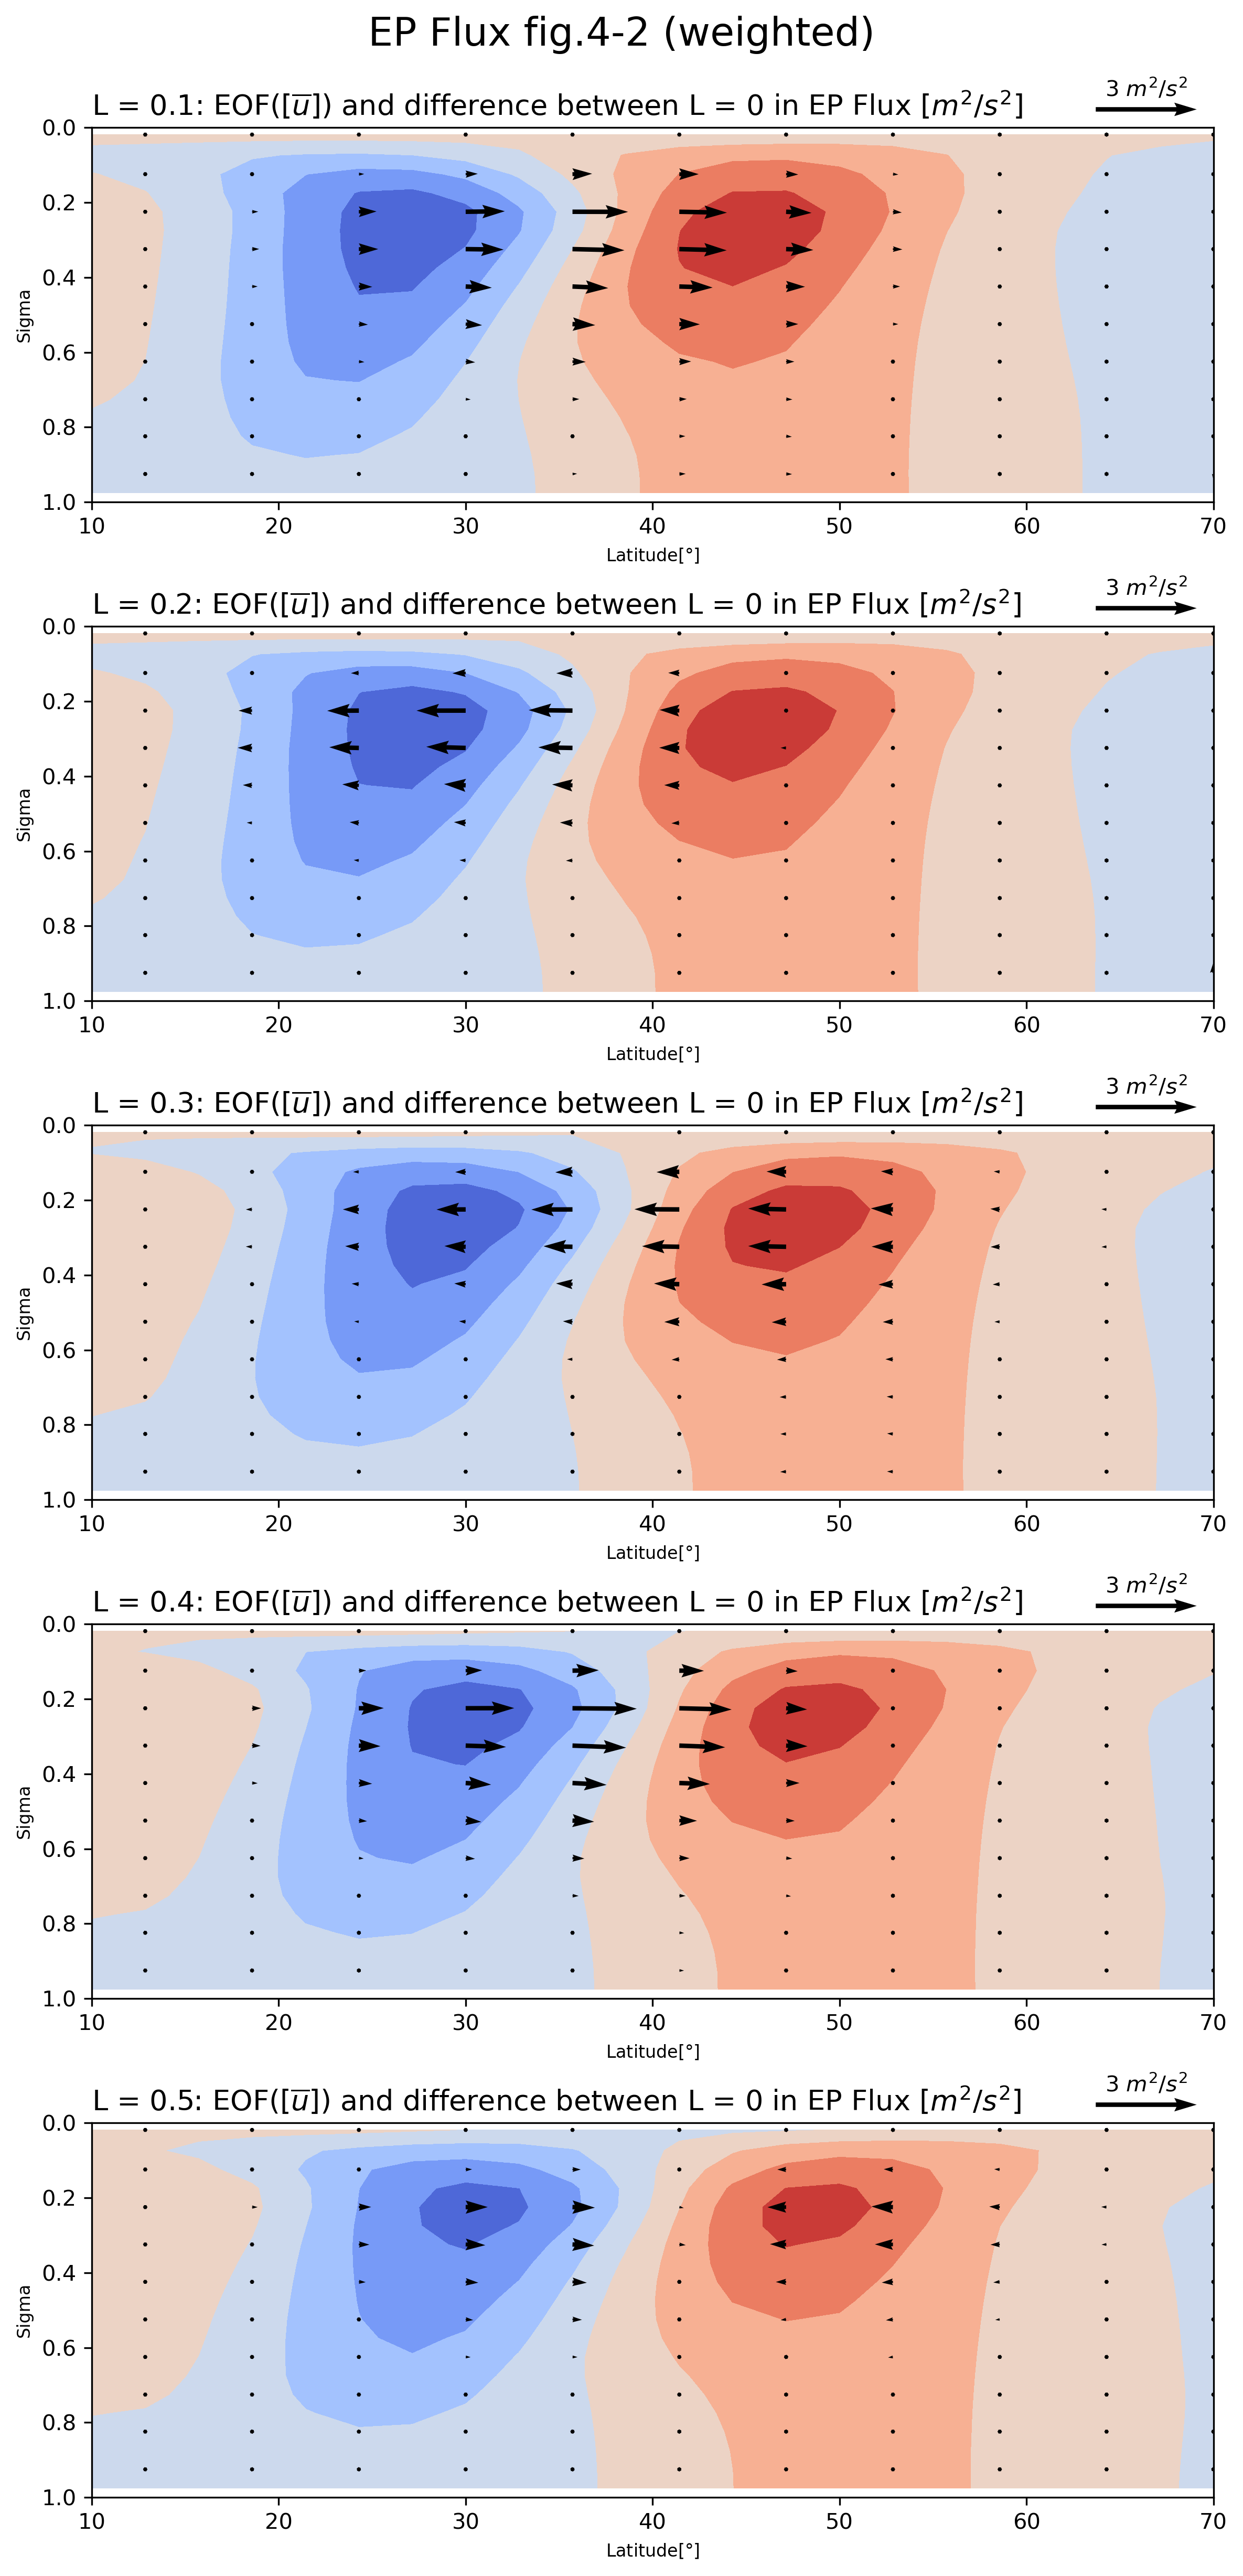

In [343]:
def load_EOF(PR, save_dir):
    EOF1 = np.load(f"{save_dir}/EOF1_PR_{PR}.npy")
    return EOF1

PR_values = range(10, 60, 10)

# Step 3: Plotting the difference in EP flux between lag = 5-20 day mean and lag = 30-60 day mean
fig, axes = plt.subplots(int(len(PR_values)), 1, figsize=(8, 16), dpi=300)

# Load the EP flux components
# F_j_mean_diff_PR0 = np.load(os.path.join(ep_flux_mean_dir, f"F_j_mean_diff_PR_0.npy"))
# F_k_mean_diff_PR0 = np.load(os.path.join(ep_flux_mean_dir, f"F_k_mean_diff_PR_0.npy"))
print(ep_flux_mean_dir)
NH_idx = 32
threshold = 0  # Wind speed threshold in m/s

for j, PR in enumerate(PR_values):
    print(j , PR)
    # Load the EP flux anomalies
    F_j_anamoly = np.load(os.path.join(ep_flux_all_time_dir, f"F_j_PR_{PR}_anamoly.npy")) # (78000, 20, 64)
    F_k_anamoly = np.load(os.path.join(ep_flux_all_time_dir, f"F_k_PR_{PR}_anamoly.npy"))
    # Load positive time indices
    time_idx_positive = np.load(os.path.join(time_idx_save_dir_1_2, f"time_idx_positive_PR_{PR}.npy"))
    # Load negative time indices
    time_idx_negative = np.load(os.path.join(time_idx_save_dir_1_2, f"time_idx_negative_PR_{PR}.npy"))
    print(f"time_idx_positive shape for PR={PR}: {np.shape(time_idx_positive)}")
    print(f"time_idx_negative shape for PR={PR}: {np.shape(time_idx_negative)}")
    

    # F_j_anamoly_mean = F_j_anamoly[time_idx_positive].mean(axis=0) - F_j_anamoly[time_idx_negative].mean(axis=0)
    # F_k_anamoly_mean = F_k_anamoly[time_idx_positive].mean(axis=0) - F_k_anamoly[time_idx_negative].mean(axis=0)
    
    F_j_anamoly_mean = F_j_anamoly[time_idx_positive].mean(axis=0) - F_j_anamoly[time_idx_negative].mean(axis=0)
    F_k_anamoly_mean = F_k_anamoly[time_idx_positive].mean(axis=0) - F_k_anamoly[time_idx_negative].mean(axis=0)

    # Load sigma for contour plotting
    sigma_file = f"/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF/PR{PR}/sigma/PR{PR}_500_20000day_6hourly_sigma_only_z.dat"
    with h5py.File(sigma_file, "r") as sigma_file0:
        sigma = np.asarray(sigma_file0["sigma"][:])

    y = np.linspace(-90, 90, 64)
    yy, zz = np.meshgrid(y, sigma)

    # Plot the difference in EP flux
    ax = axes[j]
    EOF1_PRs = load_EOF(PR, "PC1_results")
    ax.contourf(yy[:,32:], zz[:,32:], -EOF1_PRs, cmap='coolwarm')
    # Calculate wind speeds and create a mask for speeds below the threshold
    wind_speed = np.sqrt(F_j_anamoly_mean**2 + F_k_anamoly_mean**2)
    # print(wind_speed.max(), wind_speed.min())
    mask = (wind_speed >= threshold) | (wind_speed <= -threshold)
    
    # Apply the mask to filter out low-speed arrows
    F_j_anamoly_mean_nan = np.where(mask, F_j_anamoly_mean, np.nan)
    F_k_anamoly_mean_nan = np.where(mask, F_k_anamoly_mean, np.nan)
    print(np.nanmax(F_j_anamoly_mean_nan), np.nanmin(F_j_anamoly_mean_nan))

    wind_plt = ax.quiver(yy[::2, NH_idx::2], zz[::2, NH_idx::2], F_j_anamoly_mean_nan[::2, NH_idx::2], F_k_anamoly_mean_nan[::2, NH_idx::2],
              color="black", scale_units='xy', angles='xy', width=4e-3, scale=50)
    # ax.quiver(yy[::2, ::2], zz[::2, ::2], -(F_j_mean_diff[::2, ::2]), -(F_k_mean_diff[::2, ::2]),
              # color="black", scale_units='xy', angles='xy', width=4e-3, scale=2)

    ax.quiverkey(wind_plt,0.94,1.05,270,r'3 $m^2/s^2$',labelpos='N', labelsep =0.05, color='black')
    
    ax.set_ylim([1, 0])
    ax.set_xlim([10,70])
    ax.set_title(f"L = {PR * 0.01}: " + "EOF([$\overline{u}$]) and difference between L = 0 in EP Flux [$m^2/s^2$]", fontsize=13, loc="left")
    ax.set_xlabel("Latitude[$\degree$]", fontsize=8)
    ax.set_ylabel("Sigma", fontsize=8)
    

plt.tight_layout()
plt.suptitle("EP Flux fig.4-2 (weighted)", fontsize=18, y=1.02) #########################
# plt.savefig("EP Flux Original Between Lag Ranges 90 100.png", bbox_inches='tight', dpi=300.)
plt.show()

# Plot Fig.4-2 (2) x-y

In [12]:
time_idx_array_positive = np.load(os.path.join(time_idx_save_dir_1_2, f"time_idx_positive_PR_{PR}.npy"))
time_idx_array_negative = np.load(os.path.join(time_idx_save_dir_1_2, f"time_idx_negative_PR_{PR}.npy"))

In [26]:
time_idx_array_positive.shape

NameError: name 'time_idx_array_positive' is not defined

In [27]:
PR = 50
v_file_path    = "/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF" + f"/PR{PR}/v/PR{PR}_500_20000day_6hourly_v.dat"
u_file_path    = "/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF" + f"/PR{PR}/u/PR{PR}_500_20000day_6hourly_u.dat"
p_file_path    = "/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF" + f"/PR{PR}/p/PR{PR}_500_20000day_6hourly_p.dat"
prec_file_path = "/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF" + f"/PR{PR}/prec/PR{PR}_500_20000day_6hourly_prec.dat"
y = np.linspace(-90,90,64)

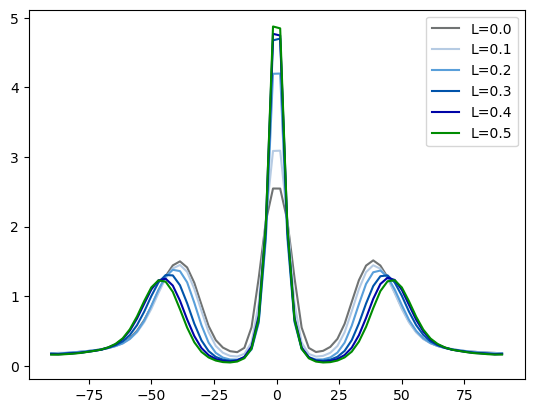

In [28]:
# Read v variable
with h5py.File(v_file_path, 'r') as file:
        v = np.asarray(file['v'][:, :, :, :])

# # Read u variable
with h5py.File(u_file_path, 'r') as file:
        u = np.asarray(file['u'][:, :, :, :])

# # Read p variable
# with h5py.File(p_file_path, 'r') as file:
#         p = np.asarray(file['p'][:, :, :, :])

# Read p variable
plt.figure()
for PR in [0, 10, 20, 30, 40, 50]:
    prec_file_path = "/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF" + f"/PR{PR}/prec/PR{PR}_500_20000day_6hourly_prec.dat"

    with h5py.File(prec_file_path, 'r') as file:
            prec = np.asarray(file['prec'][:, :, :])
        
    prec_mean = np.mean(prec, axis=(0,2)) 
    plt.plot(y, prec_mean * 86400 , label=f"L={0.01*PR}", color=colors[int(PR*0.1)])
plt.legend()
plt.show()
    

In [134]:
prec.shape

(78000, 64, 128)

In [104]:
prec.max() * 86400

185.33802834335802

In [47]:
x = np.linspace(0,360,128)
y = np.linspace(-90,90,64)

xxx, yyy = np.meshgrid(x,y)

upper_level = 5
lower_level = 6
# u_mean = u[time_idx_array_positive, upper_level:lower_level].mean(axis=(0,1)) - u[time_idx_array_negative, upper_level:lower_level].mean(axis=(0,1))
# v_mean = v[time_idx_array_positive, upper_level:lower_level].mean(axis=(0,1)) - v[time_idx_array_negative, upper_level:lower_level].mean(axis=(0,1))
# p_mean = p[time_idx_array_positive, upper_level:lower_level].mean(axis=(0,1)) - p[time_idx_array_negative, upper_level:lower_level].mean(axis=(0,1))
# prec_mean = prec.mean(axis=0) #- p[time_idx_array_negative, upper_level:lower_level].mean(axis=(0,1))


# u_mean = u[:, upper_level:lower_level].mean(axis=(0,1)) # (time, z, y, x)
# v_mean = v[:, upper_level:lower_level].mean(axis=(0,1))
# p_mean = p[:, upper_level:lower_level].mean(axis=(0,1))


u_zonal_mean = u[:,6].mean(axis=2)
v_zonal_mean = v[:,6].mean(axis=2)

u_anamoly = (u[:,6] - u_zonal_mean[:,:,np.newaxis,]).mean(axis=0)
v_anamoly = (v[:,6] - v_zonal_mean[:,:,np.newaxis,]).mean(axis=0)


In [53]:
# colors
import matplotlib.colors as colors
import matplotlib as mpl  # Add this line


rgb=([112,115,115])
rgb=np.array(rgb)/255.0
icmap=colors.ListedColormap(rgb,name='my_color')
cmap=mpl.cm.viridis

cmap_color=icmap  
# bound=[1E-4,10E-4,25E-4,50e-4,100E-4,150E-4,200E-4,250e-4]
colors = np.array([[112,115,115],[182,203,227],[89,159,218],[0,83,170],[0,4,167],[0,140,1]])/255 # By Nick
# colors = np.array([[112,115,115],[137,209,201], [18,78,120], [242,187,5],[215,78,9],[255,16,7]])/255
print(v_anamoly.max())

0.7894616
